In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import shutil
import os
from tensorflow.keras.preprocessing import image
import pandas as pd


from sklearn.metrics import classification_report

LABELS = ['negative', 'other', 'positive']
image_size=(128,128)

In [6]:
MODEL_NAME = 'resnet50_512_256_3_earlystop_accuracy_layernormalization'
model = keras.models.load_model("/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/" + MODEL_NAME)

In [7]:
def load_image(normalize=False, image_path=None, size=(128, 128)):
  '''
  Function to transform an image to normalized numpy array
  '''
  img = image.load_img(image_path, target_size=size)
  img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
  img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
  if normalize:
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
  
  return img

In [8]:
table = []

paths = ['/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/dl4cv final/negative', '/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/dl4cv final/other', '/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/dl4cv final/positive']
for i in range(3):
  p = paths[i]
  imgs = os.listdir(p)
  for img in imgs:
    img_path = p + '/' + img
    label = [0, 0, 0]
    label[i] += 1
    row = {
        'img_path': img_path,
        'img': load_image(image_path=img_path),
        'normalize_img': load_image(normalize=False, image_path=img_path, size=image_size),
        'y_true': label,
        'y_pred_reg': model.predict(load_image(image_path=img_path)),
        'y_pred_normalized': model.predict(load_image(normalize=False, image_path=img_path, size=image_size))
    }
    table.append(row)

1/1 [==============================] - 0s 112ms/step


In [9]:
df = pd.DataFrame(table)

In [10]:
df.to_csv('/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/' + MODEL_NAME + "_MY_imgs_predictions.csv", index=False)

# Evaluate

In [11]:
df['true_class'] = df['y_true'].apply(lambda x: np.argmax(x))
df['pred_reg_class'] = df['y_pred_reg'].apply(lambda x: np.argmax(x[0]))
df['pred_norm_class'] = df['y_pred_normalized'].apply(lambda x: np.argmax(x[0]))

In [12]:
print(classification_report(df['true_class'], df['pred_reg_class'], target_names=LABELS))

              precision    recall  f1-score   support

    negative       0.44      1.00      0.62         4
       other       0.00      0.00      0.00         4
    positive       0.71      0.62      0.67         8

    accuracy                           0.56        16
   macro avg       0.39      0.54      0.43        16
weighted avg       0.47      0.56      0.49        16



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print(classification_report(df['true_class'], df['pred_norm_class'], target_names=LABELS))

              precision    recall  f1-score   support

    negative       0.44      1.00      0.62         4
       other       0.00      0.00      0.00         4
    positive       0.71      0.62      0.67         8

    accuracy                           0.56        16
   macro avg       0.39      0.54      0.43        16
weighted avg       0.47      0.56      0.49        16



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Shap

## Libraries

In [15]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f594e5e3260c420441358da58bd1e920497dbf7135cf22bbc9c01cc0817a5c3d
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [16]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

IMG_SIZE = (128, 128)

## Functions

In [17]:
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    # img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0

    # mean = np.mean(img, axis=(1,2), keepdims=True)
    # std = np.std(img, axis=(1,2), keepdims=True)
    # img = (img - mean) / std
    
    return img

LABELS = ['negative', 'other', 'positive']

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {LABELS[model_prediction[0].argmax()]}")
    return LABELS[model_prediction.argmax()]

def generate_prediction_sample(exp, exp_class, weight = 0.0, show_positive = True, show_negative=False, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive,
                                         negative_only=show_negative,
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

## Negatives

In [25]:
imgs = os.listdir(paths[0])

In [26]:
print(len(imgs))

4


1/1 [==============================] - 0s 103ms/step
The predicted class is : negative


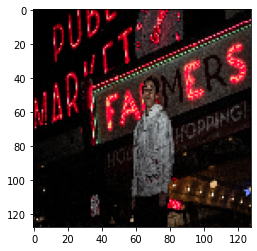

In [35]:
i = 2

img_path = paths[0] + '/' + imgs[i]
normalized_img = transform_image(img_path, IMG_SIZE)
pred_orig = get_model_predictions(normalized_img)
plt.imshow(normalized_img[0]/255.)

In [33]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(tf.cast(normalized_img[0], tf.float64).numpy(), 
                                 model.predict, 
                                 top_labels=1, 
                                 hide_color=0, 
                                 num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 595ms/step


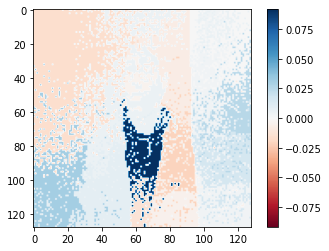

In [34]:
explanation_heatmap(exp, exp.top_labels[0])